In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

# Standard imports
import os 
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
# Ionpy imports
from ionpy.analysis import ResultsLoader
# Local imports
from ese.analysis.analyze_inf import load_cal_inference_stats

sns.set_style("darkgrid")
sns.set_context("talk")
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_dir" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    root:
        - '/storage/vbutoi/scratch/ESE/inference/11_05_24_UVS_InContext_CrossEval'
    inference_group: 
        - 'Base'
        - 'Optimal_Dice_Threshold'
        # - 'Optimal_RAVE_Threshold'

options:
    verify_graceful_exit: True
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

# Plotting Calls

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=True
)

Finished loading inference stats.
Log amounts: log_root                                                                                       log_set                                              
/storage/vbutoi/scratch/ESE/inference/11_05_24_UVS_InContext_CrossEval/Base                    20241105_110332-FGSY-77badd7cd1734748825ac49135b4887f     180
                                                                                               20241105_110335-M77Y-ae115739b9a20dea65cb92d15593735d     440
                                                                                               20241105_110340-BJ3D-671fba858a9084204bb3c56753544af8     400
                                                                                               20241105_110344-CWQB-d638adc2f532357a939ea4ad2b048c72      40
                                                                                               20241105_110429-X95K-3971a71503dc3f0b78e7de4003e9ea54      60
                   

In [4]:
inference_df['inference_data_task'].unique()

array(['PanDental/v1/XRay/0', 'SCD/VIS_human/MRI/2', 'WBC/CV/EM/0',
       'SCD/LAF_Pre/MRI/2', 'SpineWeb/Dataset7/MR/0',
       'PanDental/v2/XRay/0', 'SCD/LAS/MRI/2', 'SCD/VIS_pig/MRI/2',
       'SCD/LAF_Post/MRI/2', 'WBC/JTSC/EM/0',
       'STARE/retrieved_2021_12_06/Retinal/0', 'ACDC/Challenge2017/MRI/2'],
      dtype=object)

In [5]:
def method_group(log_root):
    suffix = log_root.split('/')[-1]
    if "Base" in suffix:
        return "Base"
    elif "Optimal" in suffix:
        return "In-Context Tuned"
    else:
        raise ValueError("Unknown method")

def task(inference_data_task):
    return inference_data_task.split('.')[-1]

inference_df.augment(method_group)
inference_df.augment(task)

In [6]:
# Only keep the rows where the image_metric is 'Dice'
methods_df = inference_df[inference_df['image_metric'] == 'Dice']
methods_df = methods_df.rename(columns={'metric_score': 'Dice'})
# methods_df = inference_df[inference_df['image_metric'] == 'hard_RAVE']
# methods_df = methods_df.rename(columns={'metric_score': 'RAVE'})

In [7]:
# We need to prune the df to the cols we care about
cols_to_keep = [
    "Dice",
    # "RAVE",
    "task",
    "data_id",
    "method_group",
]
# Prune the dataframe
analyis_df = methods_df[cols_to_keep].drop_duplicates().reset_index(drop=True)

In [8]:
analyis_df

,Dice,task,data_id,method_group
0,0.777423,PanDental/v1/XRay/0,68,Base
1,0.840065,PanDental/v1/XRay/0,26,Base
2,0.868848,PanDental/v1/XRay/0,96,Base
3,0.777188,PanDental/v1/XRay/0,10,Base
4,0.870504,PanDental/v1/XRay/0,112,Base
...,...,...,...,...
1567,0.685057,SCD/VIS_human/MRI/2,p7,In-Context Tuned
1568,0.641441,SCD/VIS_human/MRI/2,p8,In-Context Tuned
1569,0.635401,SCD/VIS_human/MRI/2,p12,In-Context Tuned
1570,0.703495,SCD/VIS_human/MRI/2,p7,In-Context Tuned


# Look at Method Performance

In [9]:
# These are the unique values of the estimator column.
analyis_df['method_group'] = analyis_df['method_group'].astype('category')
analyis_df['method_group'] = analyis_df['method_group'].cat.reorder_categories([
    'Base',
    'In-Context Tuned',
])

Text(0.5, 0.98, 'RAVE per Task, With and Without In-Context Tuning')

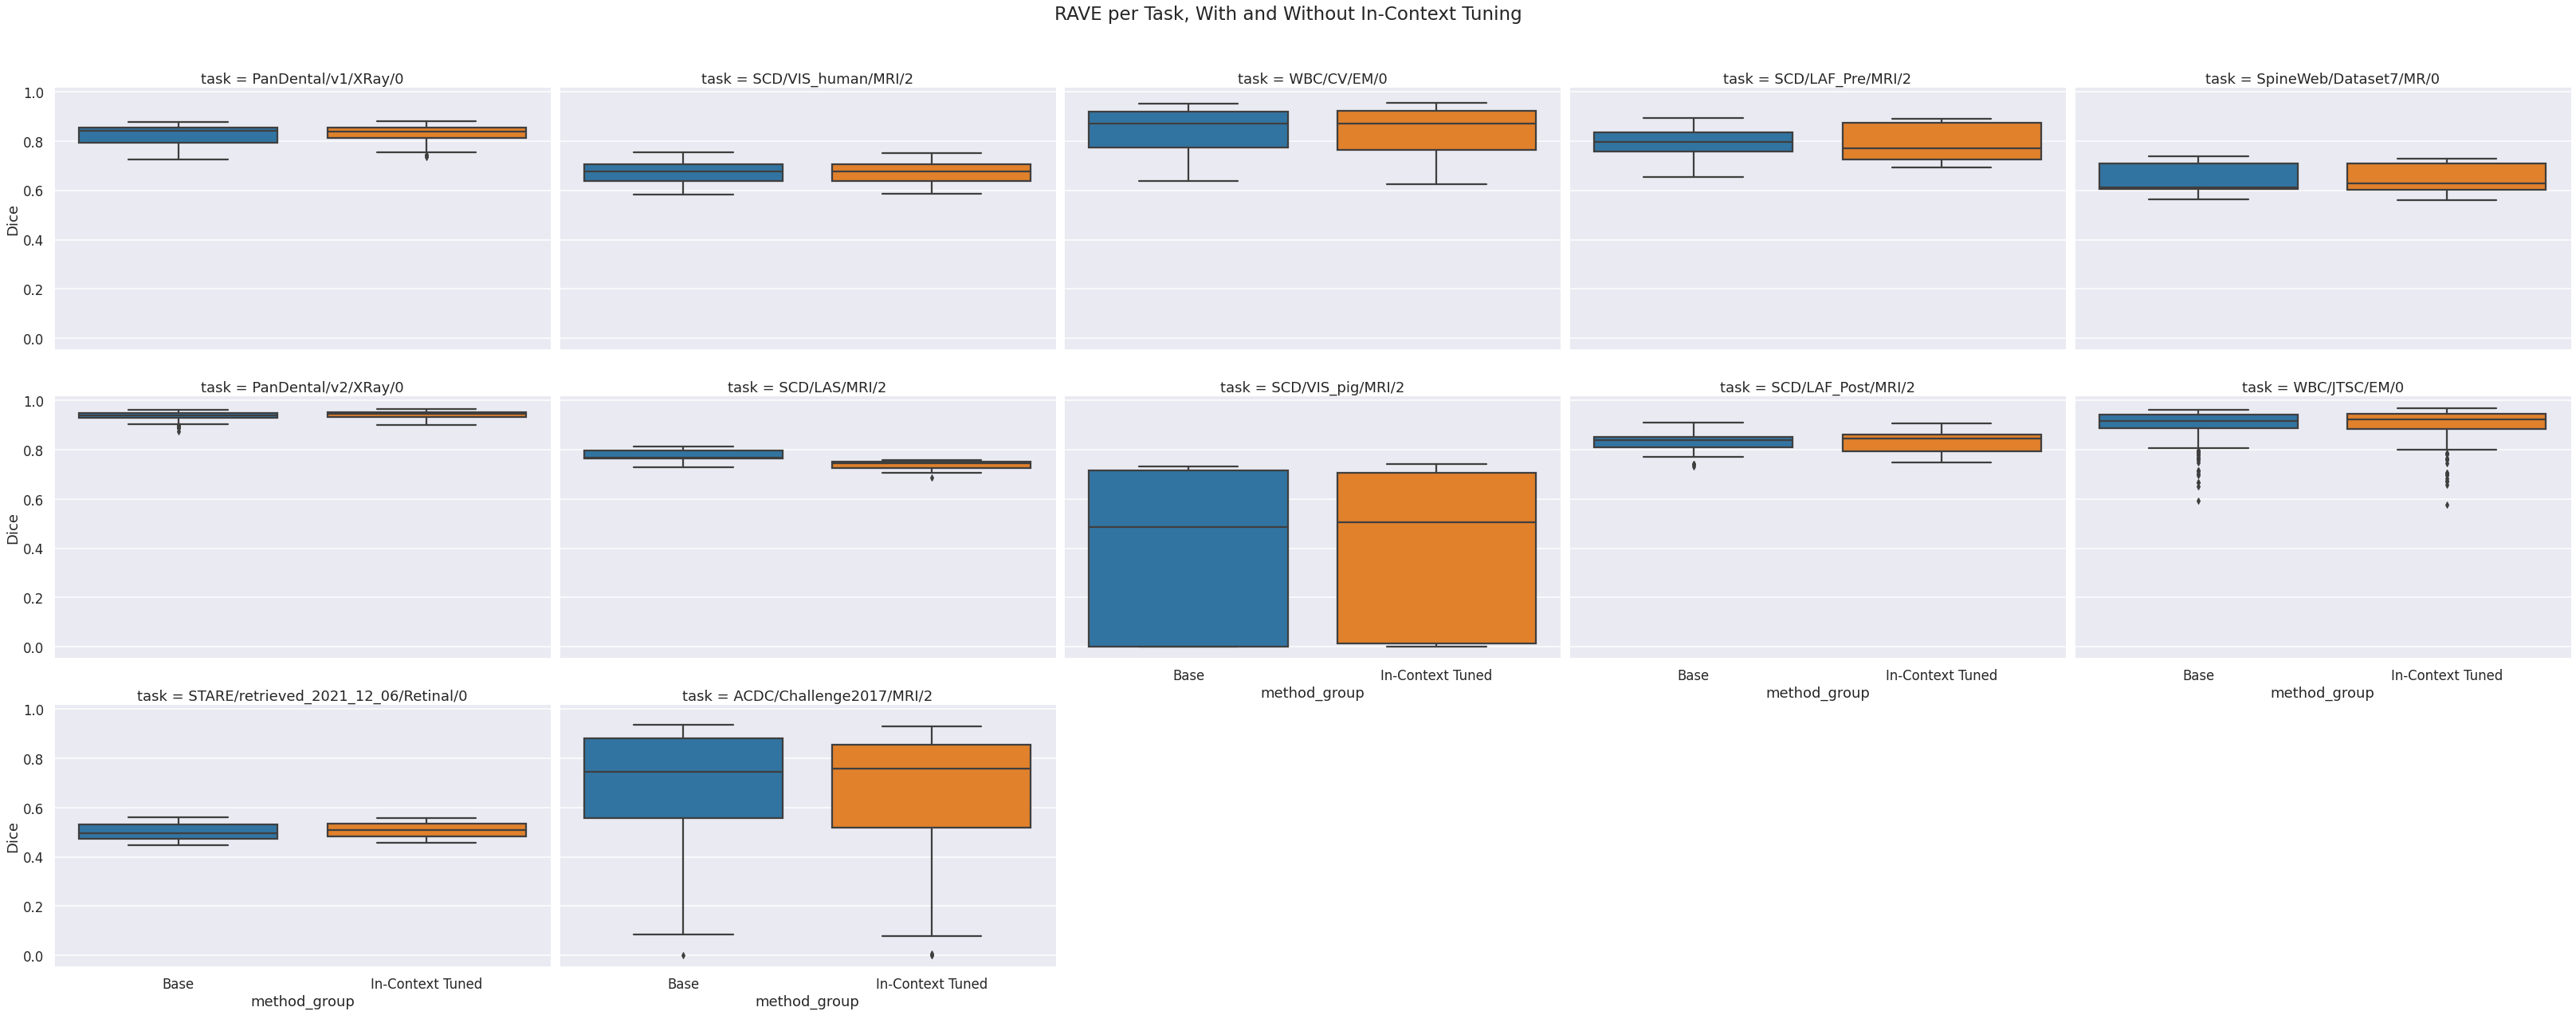

In [10]:
g = sns.catplot(
    analyis_df, 
    x='method_group', 
    y='Dice', 
    # y='RAVE', 
    kind='box',
    col='task',
    col_wrap=5,
    aspect=1.5,
    height=6,
    sharey=True
)
# We want to make a title for the plot, with some spacing 
g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle(f"Dice per Task, With and Without In-Context Tuning", fontsize=23)
g.fig.suptitle(f"RAVE per Task, With and Without In-Context Tuning", fontsize=23)

Text(0.5, 0.98, 'RAVE per Task, With and Without In-Context Tuning')

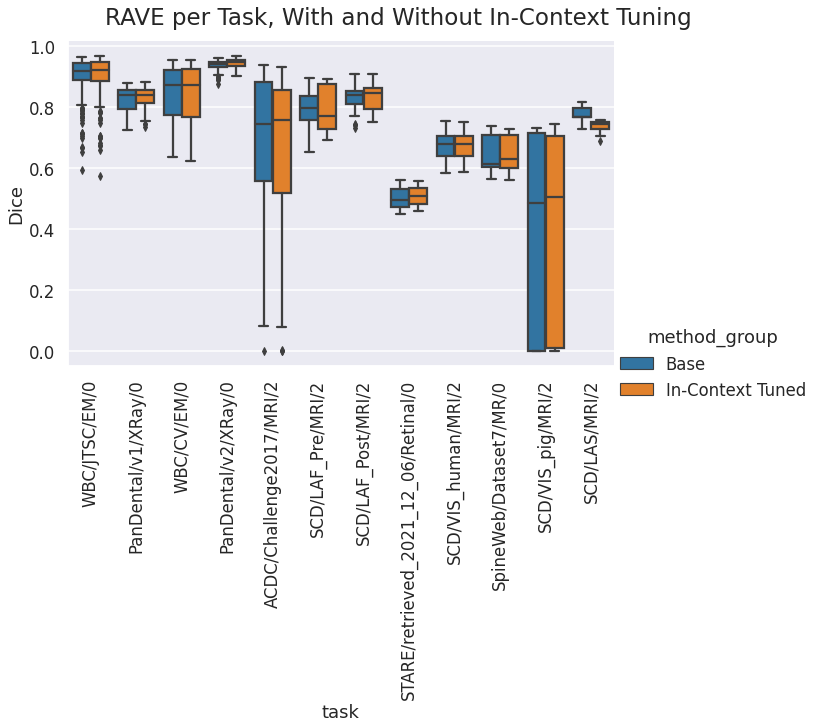

In [11]:
# I want to sort the analysis df by task, but where the ordering is determined by the number of rows belonging to each task.
task_counts = analyis_df['task'].value_counts()
task_order = task_counts.index
# Now we can sort the analysis df by the task_order
analyis_df['task'] = analyis_df['task'].astype('category')
analyis_df['task'] = analyis_df['task'].cat.reorder_categories(task_order)

g = sns.catplot(
    analyis_df, 
    x='task', 
    y='Dice', 
    # y='RAVE', 
    hue='method_group',
    kind='box',
    aspect=1.5,
    height=6,
    sharey=True
)
# Rotate the x tick labels by 90 degrees
g.set_xticklabels(rotation=90)
# We want to make a title for the plot, with some spacing 
g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle(f"Dice per Task, With and Without In-Context Tuning", fontsize=23)
g.fig.suptitle(f"RAVE per Task, With and Without In-Context Tuning", fontsize=23)

In [12]:
# g = sns.catplot(
#     analyis_df, 
#     x='data_id', 
#     y='RAVE', 
#     kind='box',
#     hue='method_group',
#     row='task',
#     aspect=1.5,
#     height=6,
#     sharex=False,
#     sharey=False
# )
# # We want to make a title for the plot, with some spacing 
# g.fig.subplots_adjust(top=0.9)
# # g.fig.suptitle(f"Dice per Task, With and Without In-Context Tuning", fontsize=23)
# g.fig.suptitle(f"RAVE per Task, With and Without In-Context Tuning", fontsize=23)